## Importar Librerias

In [1]:
import pandas as pd 
import numpy  as np 
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

print(chr(27) + "[2J")

## Importar datos 

In [2]:
dataTrain = pd.read_csv("train.csv");
dataTest  = pd.read_csv( "test.csv");

# Nan to zero
dataTrain.fillna(0);
dataTest .fillna(0);

In [3]:
## Definir features
tr = ['SalePrice']

catOrdinal = ['MSZoning','Street','Alley','LandContour','Utilities','LotConfig','Neighborhood','Condition1','Condition2',
              'BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation','Heating',
              'CentralAir','Electrical','Functional','GarageType','MiscFeature','SaleType','SaleCondition']

catNominal = {'LotShape':['Reg','IR1','IR2','IR3','NA'],
              'LandSlope':['Gtl','Mod','Sev','NA'],
              'ExterQual':['Ex','Gd','TA','Fa','Po','NA'],
              'ExterCond':['Ex','Gd','TA','Fa','Po','NA'],
              'BsmtQual':['Ex','Gd','TA','Fa','Po','NA'],
              'BsmtCond':['Ex','Gd','TA','Fa','Po','NA'],
              'BsmtExposure':['Gd','Av','Mn','No','NA'],
              'BsmtFinType1':['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NA'],
              'BsmtFinType2':['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NA'],
              'HeatingQC':['Ex','Gd','TA','Fa','Po','NA'],
              'KitchenQual':['Ex','Gd','TA','Fa','Po','NA'],
              'FireplaceQu':['Ex','Gd','TA','Fa','Po','NA'],
              'GarageQual':['Ex','Gd','TA','Fa','Po','NA'],
              'GarageCond':['Ex','Gd','TA','Fa','Po','NA'],
              'PavedDrive':['Y','P','N'],
              'PoolQC':['Ex','Gd','TA','Fa','NA'],
              'Fence':['GdPrv','MnPrv','GdWo','MnWw','NA']}

nu = ['MSSubClass','LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1',
      'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath',
      'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea',
      'WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold','SalePrice']

## Convertir datos categoricos a numericos

In [4]:
## Ordinal
for cat in catOrdinal:
    
    # Add to data train
    dummy =pd.get_dummies(dataTrain[cat],prefix=cat)
    dataTrain = pd.concat([dataTrain, dummy], axis=1, join_axes=[dataTrain.index])
    
    # Add to data test
    dummy =pd.get_dummies(dataTest[cat],prefix=cat)
    dataTest = pd.concat([dataTest, dummy], axis=1, join_axes=[dataTest.index])
    
    # Add to nu
    nu.extend(dummy.columns.tolist())
    
## Nominal
for cat in catNominal.keys():
    
    # Get domains
    dom = catNominal[cat]
    
    # Add to data train
    catNum = [dom.index(x) for x in dataTrain[cat].fillna('NA')  ]
    dataTrain[cat+'_Num'] = pd.Series(catNum, index=dataTrain.index)
    
    # Add to data test
    catNum = [dom.index(x) for x in dataTest[cat].fillna('NA')  ]
    dataTest[cat+'_Num'] = pd.Series(catNum, index=dataTest.index)
    
    # Add to nu
    nu.append(cat+'_Num')

## Data selection

In [5]:
# Pearson correlation
pearson  = dataTrain[nu].corr('pearson' )
spearman = dataTrain[nu].corr('spearman')

pearson  =  pearson[tr]
spearman = spearman[tr]

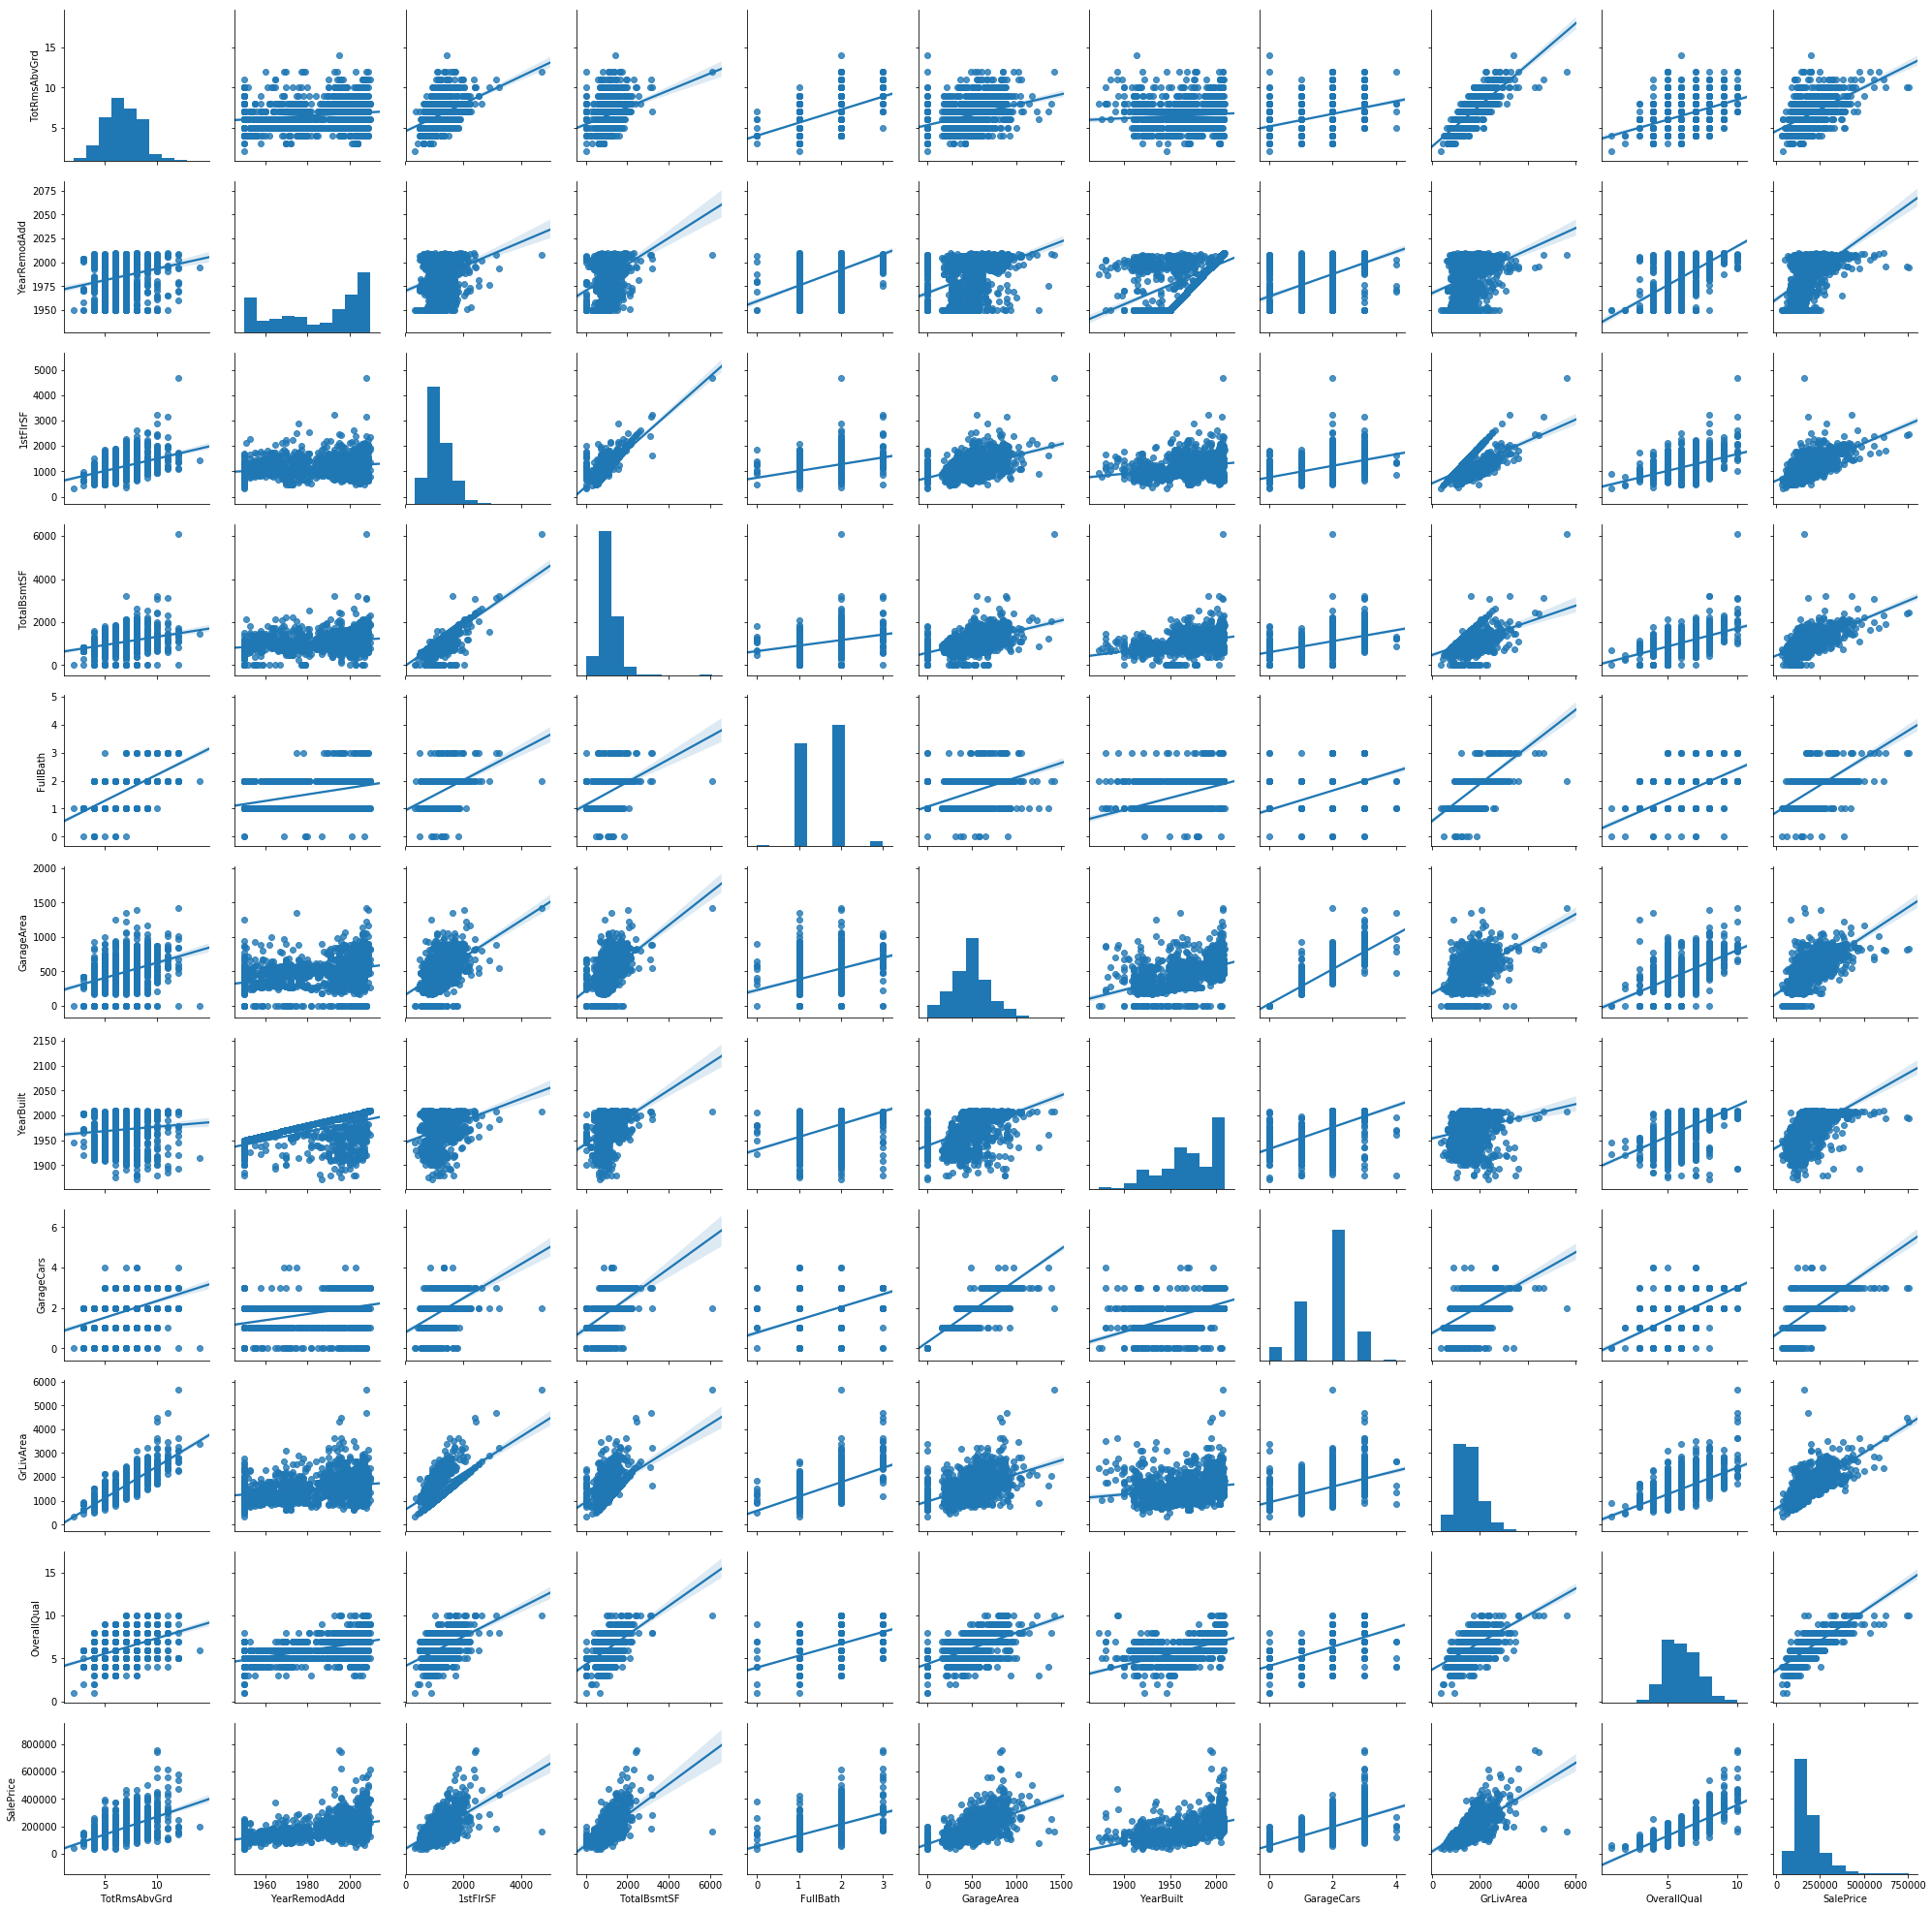

In [37]:
# Data selection
umb = 0.5
select_pearson  = pearson [ pearson > umb].dropna().abs().sort_values(tr).index.tolist()
select_spearman = spearman[spearman > umb].dropna().abs().sort_values(tr).index.tolist()
select_nu = [x for x in select_spearman if x in select_pearson]

df = dataTrain[ select_nu ]

## Plot correlation of selected features
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(dataTrain[select_nu], kind="reg")


## Preprocessing

In [7]:
ymean = df['SalePrice'].mean()
ystd  = df['SalePrice'].std ()
df = (df-df.mean())/df.std()

x = df[ select_nu[:-1] ].values
y = df[ select_nu[ -1] ].values.reshape(-1, 1)

# Cross-validation
kf = KFold(n_splits=8)

## Python Linear Regression

In [8]:
MAE = list(); MSE = list(); RMSE = list()
for train, test in kf.split(x):
    # Select
    x_train = x[train]; y_train = y[train]
    x_test  = x[test ]; y_test  = y[test ]
    
    # Regression
    regr = LinearRegression()
    
    # Train
    regr.fit(x,y)
    
    # Test
    y_pred = regr.predict( x_test )
    
    # Metrics
    MAE .append(        metrics.mean_absolute_error(y_test, y_pred) )
    MSE .append(        metrics.mean_squared_error (y_test, y_pred) )
    RMSE.append(np.sqrt(metrics.mean_squared_error (y_test, y_pred)))
    
print('Python Linear Regression:')
print('MAE =',np.average(MAE),'\tMSE =',np.average(MSE),'\tRMSE =',np.average(RMSE))

Python Linear Regression:
MAE = 0.3000885840727423 	MSE = 0.22620592910759893 	RMSE = 0.47048755895692307


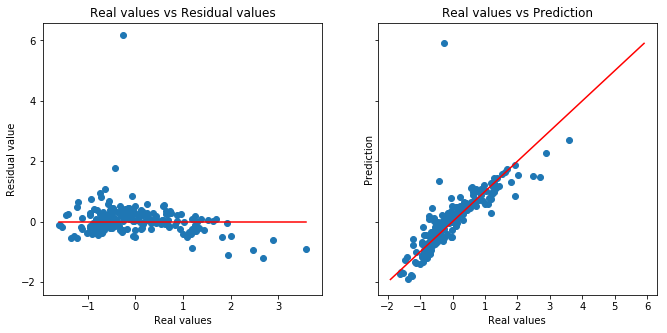

In [9]:
line = [min([min(y_test),min(y_pred)]) , max([max(y_test),max(y_pred)]) ]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight( 5)
f.set_figwidth (11)

residual = y_pred-y_test
ax1.plot([ min(y_test) , max(y_test) ],[0,0],color='r')
ax1.scatter(y_test,residual)
ax1.set_title('Real values vs Residual values')
ax1.set_xlabel('Real values')
ax1.set_ylabel('Residual value')

ax2.plot(line,line,color='r')
ax2.scatter(y_test,y_pred)
ax2.set_title('Real values vs Prediction')
ax2.set_xlabel('Real values')
ax2.set_ylabel('Prediction')

plt.show()

## Batch Gradient Descent

In [10]:
def BatchGradientDescent(x_train,y_train,x_test):
    
    # Parameters
    alpha     = 0.001
    err       = 1000
    errNorm   = 1000
    threshold = 0.001
    
    n_predictor = len(x_train[0])
    n_samples   = len(y_train   )
    theta = np.zeros([n_predictor + 1,1])
    
    # Train Loop
    while (errNorm>threshold):
        exErr = err
        err   = 0
        
        # Cost function
        y_pred = np.dot(x_train,theta[:-1]) + theta[:][-1]
        J =  (1.0/n_samples)*  np.dot( x_train.T, y_train - y_pred)
        
        # Theta calculation
        for i in range( n_predictor ):
            theta[i] = theta[i] + alpha *np.dot(x_train[:][i],J)  
        
        # Error
        err = np.sum(np.abs(y_train - y_pred))
        
        # Update error
        errNorm = np.abs(exErr - err)/np.abs(err)
        
    return np.dot(x_test,theta[:][:-1]) + theta[:][-1]

MAE = list(); MSE = list(); RMSE = list()
for train, test in kf.split(x):
    # Select
    x_train = x[train]; y_train = y[train]
    x_test  = x[test ]; y_test  = y[test ]
    
    # Stochastic Gradient Descent
    y_pred = BatchGradientDescent(x_train,y_train,x_test)
    
    # Metrics
    MAE .append(        metrics.mean_absolute_error(y_test, y_pred) )
    MSE .append(        metrics.mean_squared_error (y_test, y_pred) )
    RMSE.append(np.sqrt(metrics.mean_squared_error (y_test, y_pred)))
    
print('Batch Gradient Descent:')
print('MAE =',np.average(MAE),'\tMSE =',np.average(MSE),'\tRMSE =',np.average(RMSE))

Batch Gradient Descent:
MAE = 0.5863927274195377 	MSE = 0.7225175854281825 	RMSE = 0.8440437179855252


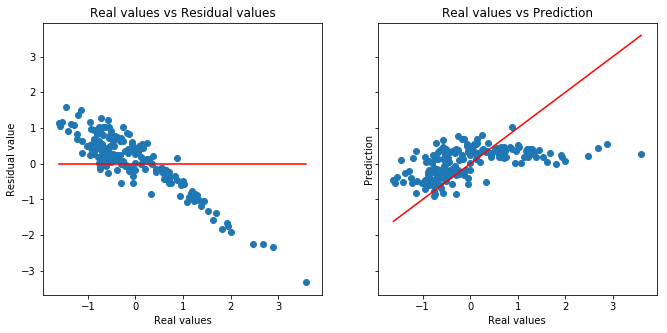

In [11]:
line = [min([min(y_test),min(y_pred)]) , max([max(y_test),max(y_pred)]) ]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight( 5)
f.set_figwidth (11)

residual = y_pred-y_test
ax1.plot([ min(y_test) , max(y_test) ],[0,0],color='r')
ax1.scatter(y_test,residual)
ax1.set_title('Real values vs Residual values')
ax1.set_xlabel('Real values')
ax1.set_ylabel('Residual value')

ax2.plot(line,line,color='r')
ax2.scatter(y_test,y_pred)
ax2.set_title('Real values vs Prediction')
ax2.set_xlabel('Real values')
ax2.set_ylabel('Prediction')

plt.show()

## Stochastic Gradient Descent

In [12]:
def StochasticGradientDescent(x_train,y_train,x_test):
    
    # Parameters
    alpha     = 0.001
    err       = 1000
    errNorm   = 1000
    threshold = 0.00001
    
    theta = np.zeros( len(x_train[0]) )
    
    # Train Loop
    while (errNorm>threshold):
        exErr = err
        err   = 0
        for xs, ys in zip(x,y):
            #xs = np.append(xs,1)
            y_pred = theta * xs
            
            # Theta
            theta  = theta + alpha * (ys - y_pred) * xs
            
            # Error
            err = err + np.sum(np.abs(ys - y_pred))
            
        # Update error
        errNorm = np.abs(exErr - err)/np.abs(err)
        
    return np.dot(x_test,theta)

MAE = list(); MSE = list(); RMSE = list()
for train, test in kf.split(x):
    # Select
    x_train = x[train]; y_train = y[train]
    x_test  = x[test ]; y_test  = y[test ]
    
    # Stochastic Gradient Descent
    y_pred = StochasticGradientDescent(x_train,y_train,x_test)
    
    # Metrics
    MAE .append(        metrics.mean_absolute_error(y_test, y_pred) )
    MSE .append(        metrics.mean_squared_error (y_test, y_pred) )
    RMSE.append(np.sqrt(metrics.mean_squared_error (y_test, y_pred)))
    
print('Stochastic Gradient Descent:')
print('MAE =',np.average(MAE),'\tMSE =',np.average(MSE),'\tRMSE =',np.average(RMSE))

Stochastic Gradient Descent:
MAE = 2.830002301416094 	MSE = 11.966148505368189 	RMSE = 3.448661618085362


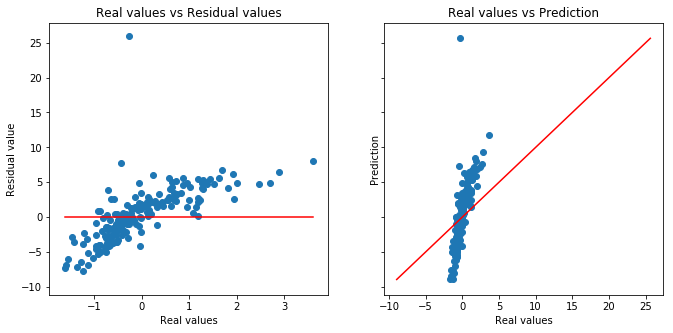

In [13]:
line = [min([min(y_test),min(y_pred)]) , max([max(y_test),max(y_pred)]) ]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight( 5)
f.set_figwidth (11)

residual = y_pred-y_test.T[0]
ax1.plot([ min(y_test) , max(y_test) ],[0,0],color='r')
ax1.scatter(y_test,residual)
ax1.set_title('Real values vs Residual values')
ax1.set_xlabel('Real values')
ax1.set_ylabel('Residual value')

ax2.plot(line,line,color='r')
ax2.scatter(y_test,y_pred)
ax2.set_title('Real values vs Prediction')
ax2.set_xlabel('Real values')
ax2.set_ylabel('Prediction')

plt.show()

## Random Forest Regressor

In [14]:
MAE = list(); MSE = list(); RMSE = list()
import warnings
warnings.filterwarnings("ignore")
for train, test in kf.split(x):
    # Select
    x_train = x[train]; y_train = y[train]
    x_test  = x[test ]; y_test  = y[test ]
    
    # Regression
    regr = RandomForestRegressor(random_state=0,n_estimators=100)
    
    # Train
    regr.fit(x_train,y_train)
    
    # Test
    y_pred = regr.predict( x_test )
    
    # Metrics
    MAE .append(        metrics.mean_absolute_error(y_test, y_pred) )
    MSE .append(        metrics.mean_squared_error (y_test, y_pred) )
    RMSE.append(np.sqrt(metrics.mean_squared_error (y_test, y_pred)))
    
print('Random Forest Regressor:')
print('MAE =',np.average(MAE),'\tMSE =',np.average(MSE),'\tRMSE =',np.average(RMSE))

Random Forest Regressor:
MAE = 0.2505450847472453 	MSE = 0.16222980298818174 	RMSE = 0.39681870002120256


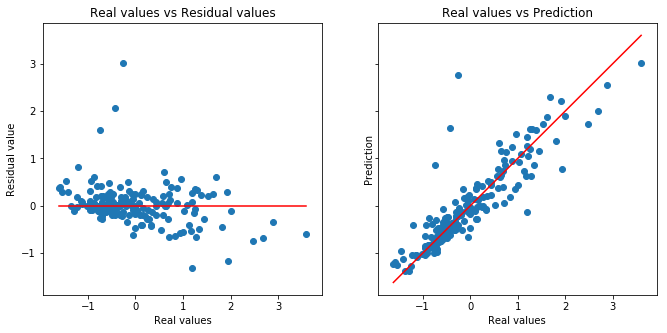

In [15]:
line = [min([min(y_test),min(y_pred)]) , max([max(y_test),max(y_pred)]) ]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight( 5)
f.set_figwidth (11)

residual = y_pred-y_test.T[0]
ax1.plot([ min(y_test) , max(y_test) ],[0,0],color='r')
ax1.scatter(y_test,residual)
ax1.set_title('Real values vs Residual values')
ax1.set_xlabel('Real values')
ax1.set_ylabel('Residual value')

ax2.plot(line,line,color='r')
ax2.scatter(y_test,y_pred)
ax2.set_title('Real values vs Prediction')
ax2.set_xlabel('Real values')
ax2.set_ylabel('Prediction')

plt.show()

## Gradient Boosting Regressor

In [16]:
MAE = list(); MSE = list(); RMSE = list()
import warnings
warnings.filterwarnings("ignore")
for train, test in kf.split(x):
    # Select
    x_train = x[train]; y_train = y[train]
    x_test  = x[test ]; y_test  = y[test ]
    
    # Regression
    regr = GradientBoostingRegressor(random_state=0,n_estimators=100)
    
    # Train
    regr.fit(x_train,y_train)
    
    # Test
    y_pred = regr.predict( x_test )
    
    # Metrics
    MAE .append(        metrics.mean_absolute_error(y_test, y_pred) )
    MSE .append(        metrics.mean_squared_error (y_test, y_pred) )
    RMSE.append(np.sqrt(metrics.mean_squared_error (y_test, y_pred)))
    
print('Gradient Boosting Regressor:')
print('MAE =',np.average(MAE),'\tMSE =',np.average(MSE),'\tRMSE =',np.average(RMSE))

Gradient Boosting Regressor:
MAE = 0.239698397369006 	MSE = 0.14351731685081806 	RMSE = 0.3735532901593111


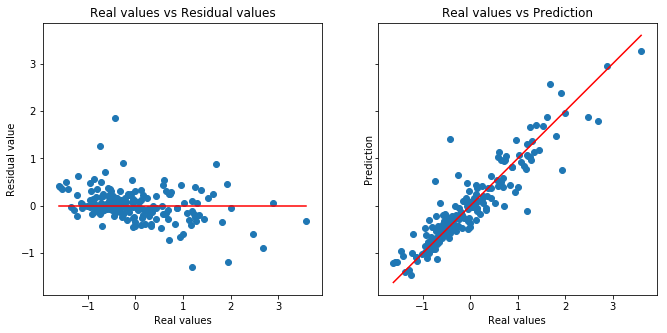

In [17]:
line = [min([min(y_test),min(y_pred)]) , max([max(y_test),max(y_pred)]) ]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight( 5)
f.set_figwidth (11)

residual = y_pred-y_test.T[0]
ax1.plot([ min(y_test) , max(y_test) ],[0,0],color='r')
ax1.scatter(y_test,residual)
ax1.set_title('Real values vs Residual values')
ax1.set_xlabel('Real values')
ax1.set_ylabel('Residual value')

ax2.plot(line,line,color='r')
ax2.scatter(y_test,y_pred)
ax2.set_title('Real values vs Prediction')
ax2.set_xlabel('Real values')
ax2.set_ylabel('Prediction')

plt.show()

## LASSO Regression

In [18]:
MAE = list(); MSE = list(); RMSE = list()
for train, test in kf.split(x):
    # Select
    x_train = x[train]; y_train = y[train]
    x_test  = x[test ]; y_test  = y[test ]
    
    # Regression
    regr = linear_model.Lasso(alpha=0.0001)
    
    # Train
    regr.fit(x,y)
    
    # Test
    y_pred = regr.predict( x_test )
    
    # Metrics
    MAE .append(        metrics.mean_absolute_error(y_test, y_pred) )
    MSE .append(        metrics.mean_squared_error (y_test, y_pred) )
    RMSE.append(np.sqrt(metrics.mean_squared_error (y_test, y_pred)))
    
print('LASSO Regression:')
print('MAE =',np.average(MAE),'\tMSE =',np.average(MSE),'\tRMSE =',np.average(RMSE))

LASSO Regression:
MAE = 0.30008320396275884 	MSE = 0.22620597221658456 	RMSE = 0.47049196614300115


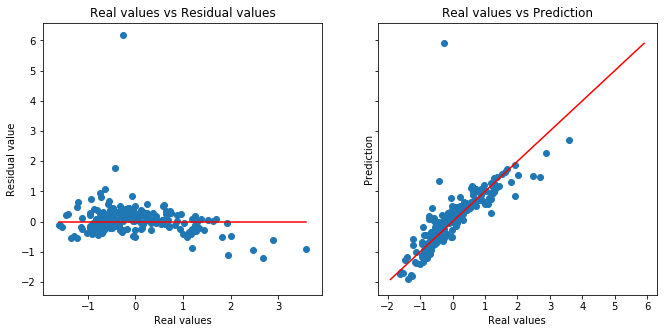

In [19]:
line = [min([min(y_test),min(y_pred)]) , max([max(y_test),max(y_pred)]) ]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight( 5)
f.set_figwidth (11)

residual = y_pred-y_test.T[0]
ax1.plot([ min(y_test) , max(y_test) ],[0,0],color='r')
ax1.scatter(y_test,residual)
ax1.set_title('Real values vs Residual values')
ax1.set_xlabel('Real values')
ax1.set_ylabel('Residual value')

ax2.plot(line,line,color='r')
ax2.scatter(y_test,y_pred)
ax2.set_title('Real values vs Prediction')
ax2.set_xlabel('Real values')
ax2.set_ylabel('Prediction')

plt.show()

## PLS Regression

In [20]:
from sklearn.cross_decomposition import PLSRegression
MAE = list(); MSE = list(); RMSE = list()

for train, test in kf.split(x):
    # Select
    x_train = x[train]; y_train = y[train]
    x_test  = x[test ]; y_test  = y[test ]
    
    # Regression
    regr = PLSRegression(n_components=5)
    
    # Train
    regr.fit(x,y)
    
    # Test
    y_pred = regr.predict( x_test )
    
    # Metrics
    MAE .append(        metrics.mean_absolute_error(y_test, y_pred) )
    MSE .append(        metrics.mean_squared_error (y_test, y_pred) )
    RMSE.append(np.sqrt(metrics.mean_squared_error (y_test, y_pred)))
    
print('PLS Regression:')
print('MAE =',np.average(MAE),'\tMSE =',np.average(MSE),'\tRMSE =',np.average(RMSE))

PLS Regression:
MAE = 0.3001638922817262 	MSE = 0.22636666670173694 	RMSE = 0.4706946935787867


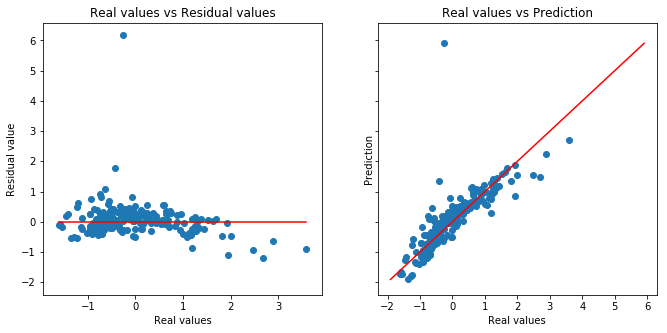

In [22]:
line = [min([min(y_test),min(y_pred)]) , max([max(y_test),max(y_pred)]) ]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight( 5)
f.set_figwidth (11)

residual = y_pred-y_test
ax1.plot([ min(y_test) , max(y_test) ],[0,0],color='r')
ax1.scatter(y_test,residual)
ax1.set_title('Real values vs Residual values')
ax1.set_xlabel('Real values')
ax1.set_ylabel('Residual value')

ax2.plot(line,line,color='r')
ax2.scatter(y_test,y_pred)
ax2.set_title('Real values vs Prediction')
ax2.set_xlabel('Real values')
ax2.set_ylabel('Prediction')

plt.show()

## Gaussian process regression

In [23]:
from sklearn.gaussian_process import GaussianProcessRegressor
MAE = list(); MSE = list(); RMSE = list()

for train, test in kf.split(x):
    # Select
    x_train = x[train]; y_train = y[train]
    x_test  = x[test ]; y_test  = y[test ]
    
    # Regression
    regr = GaussianProcessRegressor(random_state=0)
    
    # Train
    regr.fit(x,y)
    
    # Test
    y_pred = regr.predict( x_test )
    
    # Metrics
    MAE .append(        metrics.mean_absolute_error(y_test, y_pred) )
    MSE .append(        metrics.mean_squared_error (y_test, y_pred) )
    RMSE.append(np.sqrt(metrics.mean_squared_error (y_test, y_pred)))
    
print('Gaussian process regression :')
print('MAE =',np.average(MAE),'\tMSE =',np.average(MSE),'\tRMSE =',np.average(RMSE))

Gaussian process regression :
MAE = 0.001221215071517864 	MSE = 0.00010873629281634567 	RMSE = 0.009570662607088866


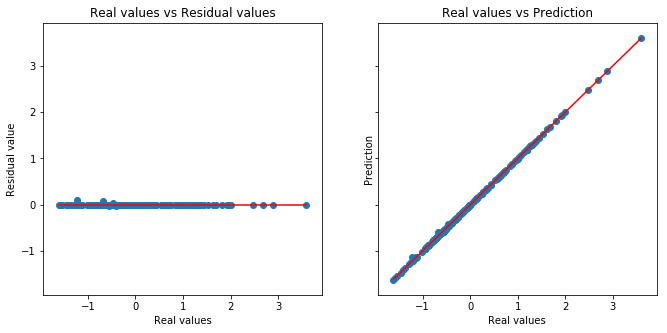

In [25]:
line = [min([min(y_test),min(y_pred)]) , max([max(y_test),max(y_pred)]) ]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight( 5)
f.set_figwidth (11)

residual = y_pred-y_test
ax1.plot([ min(y_test) , max(y_test) ],[0,0],color='r')
ax1.scatter(y_test,residual)
ax1.set_title('Real values vs Residual values')
ax1.set_xlabel('Real values')
ax1.set_ylabel('Residual value')

ax2.plot(line,line,color='r')
ax2.scatter(y_test,y_pred)
ax2.set_title('Real values vs Prediction')
ax2.set_xlabel('Real values')
ax2.set_ylabel('Prediction')

plt.show()

## Huber Regressor

In [26]:
from sklearn.linear_model import HuberRegressor
MAE = list(); MSE = list(); RMSE = list()

for train, test in kf.split(x):
    # Select
    x_train = x[train]; y_train = y[train]
    x_test  = x[test ]; y_test  = y[test ]
    
    # Regression
    regr = HuberRegressor()
    
    # Train
    regr.fit(x,y)
    
    # Test
    y_pred = regr.predict( x_test )
    
    # Metrics
    MAE .append(        metrics.mean_absolute_error(y_test, y_pred) )
    MSE .append(        metrics.mean_squared_error (y_test, y_pred) )
    RMSE.append(np.sqrt(metrics.mean_squared_error (y_test, y_pred)))
    
print('Huber Regressor:')
print('MAE =',np.average(MAE),'\tMSE =',np.average(MSE),'\tRMSE =',np.average(RMSE))

Huber Regressor:
MAE = 0.2880854197491488 	MSE = 0.23538884564241686 	RMSE = 0.4792958896527335


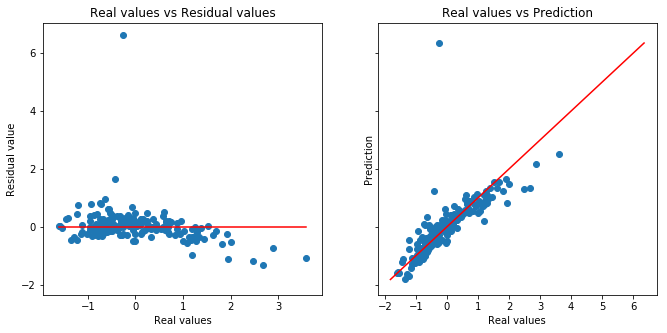

In [27]:
line = [min([min(y_test),min(y_pred)]) , max([max(y_test),max(y_pred)]) ]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight( 5)
f.set_figwidth (11)

residual = y_pred-y_test.T[0]
ax1.plot([ min(y_test) , max(y_test) ],[0,0],color='r')
ax1.scatter(y_test,residual)
ax1.set_title('Real values vs Residual values')
ax1.set_xlabel('Real values')
ax1.set_ylabel('Residual value')

ax2.plot(line,line,color='r')
ax2.scatter(y_test,y_pred)
ax2.set_title('Real values vs Prediction')
ax2.set_xlabel('Real values')
ax2.set_ylabel('Prediction')

plt.show()

## RANSAC Regressor

In [28]:
from sklearn.linear_model import RANSACRegressor
MAE = list(); MSE = list(); RMSE = list()

for train, test in kf.split(x):
    # Select
    x_train = x[train]; y_train = y[train]
    x_test  = x[test ]; y_test  = y[test ]
    
    # Regression
    regr = RANSACRegressor(random_state=0)
    
    # Train
    regr.fit(x,y)
    
    # Test
    y_pred = regr.predict( x_test )
    
    # Metrics
    MAE .append(        metrics.mean_absolute_error(y_test, y_pred) )
    MSE .append(        metrics.mean_squared_error (y_test, y_pred) )
    RMSE.append(np.sqrt(metrics.mean_squared_error (y_test, y_pred)))
    
print('RANSAC Regressor:')
print('MAE =',np.average(MAE),'\tMSE =',np.average(MSE),'\tRMSE =',np.average(RMSE))

RANSAC Regressor:
MAE = 0.32915613089884255 	MSE = 0.30771823606979287 	RMSE = 0.5513455041477547


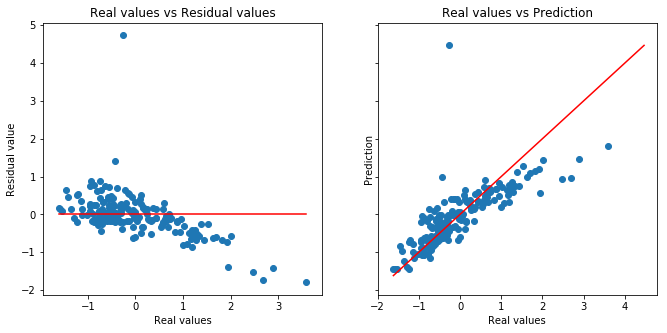

In [30]:
line = [min([min(y_test),min(y_pred)]) , max([max(y_test),max(y_pred)]) ]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight( 5)
f.set_figwidth (11)

residual = y_pred-y_test
ax1.plot([ min(y_test) , max(y_test) ],[0,0],color='r')
ax1.scatter(y_test,residual)
ax1.set_title('Real values vs Residual values')
ax1.set_xlabel('Real values')
ax1.set_ylabel('Residual value')

ax2.plot(line,line,color='r')
ax2.scatter(y_test,y_pred)
ax2.set_title('Real values vs Prediction')
ax2.set_xlabel('Real values')
ax2.set_ylabel('Prediction')

plt.show()

## Linear Support Vector Regression

In [31]:
from sklearn.svm import LinearSVR
MAE = list(); MSE = list(); RMSE = list()

for train, test in kf.split(x):
    # Select
    x_train = x[train]; y_train = y[train]
    x_test  = x[test ]; y_test  = y[test ]
    
    # Regression
    regr = LinearSVR(random_state=0, tol=1e-8)
    
    # Train
    regr.fit(x,y)
    
    # Test
    y_pred = regr.predict( x_test )
    
    # Metrics
    MAE .append(        metrics.mean_absolute_error(y_test, y_pred) )
    MSE .append(        metrics.mean_squared_error (y_test, y_pred) )
    RMSE.append(np.sqrt(metrics.mean_squared_error (y_test, y_pred)))
    
print('Linear Support Vector Regression:')
print('MAE =',np.average(MAE),'\tMSE =',np.average(MSE),'\tRMSE =',np.average(RMSE))

Linear Support Vector Regression:
MAE = 0.2872772078654843 	MSE = 0.24156908598881385 	RMSE = 0.486137715919148


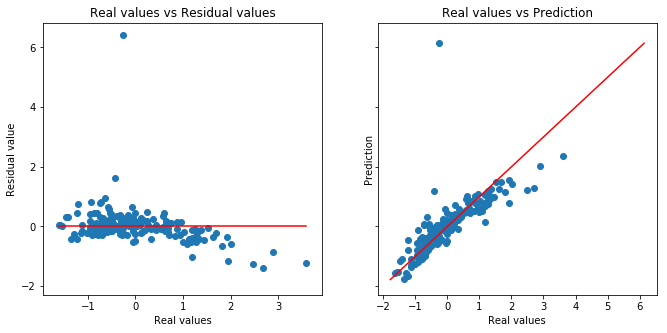

In [32]:
line = [min([min(y_test),min(y_pred)]) , max([max(y_test),max(y_pred)]) ]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight( 5)
f.set_figwidth (11)

residual = y_pred-y_test.T[0]
ax1.plot([ min(y_test) , max(y_test) ],[0,0],color='r')
ax1.scatter(y_test,residual)
ax1.set_title('Real values vs Residual values')
ax1.set_xlabel('Real values')
ax1.set_ylabel('Residual value')

ax2.plot(line,line,color='r')
ax2.scatter(y_test,y_pred)
ax2.set_title('Real values vs Prediction')
ax2.set_xlabel('Real values')
ax2.set_ylabel('Prediction')

plt.show()

## Nu Support Vector Regression

In [33]:
from sklearn.svm import NuSVR
MAE = list(); MSE = list(); RMSE = list()

for train, test in kf.split(x):
    # Select
    x_train = x[train]; y_train = y[train]
    x_test  = x[test ]; y_test  = y[test ]
    
    # Regression
    regr = NuSVR(tol=1e-6)
    
    # Train
    regr.fit(x,y)
    
    # Test
    y_pred = regr.predict( x_test )
    
    # Metrics
    MAE .append(        metrics.mean_absolute_error(y_test, y_pred) )
    MSE .append(        metrics.mean_squared_error (y_test, y_pred) )
    RMSE.append(np.sqrt(metrics.mean_squared_error (y_test, y_pred)))
    
print('Nu Support Vector Regression:')
print('MAE =',np.average(MAE),'\tMSE =',np.average(MSE),'\tRMSE =',np.average(RMSE))

Nu Support Vector Regression:
MAE = 0.2030232177659145 	MSE = 0.1164613149885 	RMSE = 0.33595599333945453


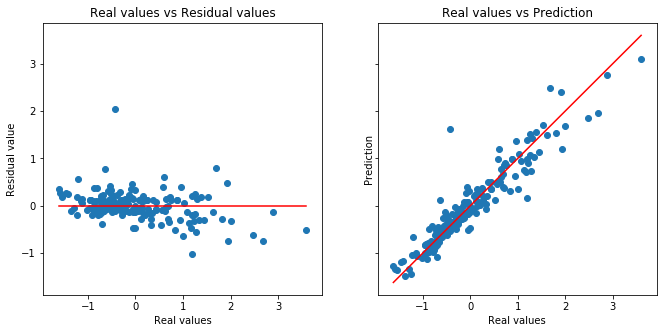

In [34]:
line = [min([min(y_test),min(y_pred)]) , max([max(y_test),max(y_pred)]) ]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight( 5)
f.set_figwidth (11)

residual = y_pred-y_test.T[0]
ax1.plot([ min(y_test) , max(y_test) ],[0,0],color='r')
ax1.scatter(y_test,residual)
ax1.set_title('Real values vs Residual values')
ax1.set_xlabel('Real values')
ax1.set_ylabel('Residual value')

ax2.plot(line,line,color='r')
ax2.scatter(y_test,y_pred)
ax2.set_title('Real values vs Prediction')
ax2.set_xlabel('Real values')
ax2.set_ylabel('Prediction')

plt.show()

## Epsilon-Support Vector Regression

In [35]:
from sklearn.svm import SVR
MAE = list(); MSE = list(); RMSE = list()

for train, test in kf.split(x):
    # Select
    x_train = x[train]; y_train = y[train]
    x_test  = x[test ]; y_test  = y[test ]
    
    # Regression
    regr = SVR(tol=1e-6)
    
    # Train
    regr.fit(x,y)
    
    # Test
    y_pred = regr.predict( x_test )
    
    # Metrics
    MAE .append(        metrics.mean_absolute_error(y_test, y_pred) )
    MSE .append(        metrics.mean_squared_error (y_test, y_pred) )
    RMSE.append(np.sqrt(metrics.mean_squared_error (y_test, y_pred)))
    
print('Epsilon-Support Vector Regression:')
print('MAE =',np.average(MAE),'\tMSE =',np.average(MSE),'\tRMSE =',np.average(RMSE))

Epsilon-Support Vector Regression:
MAE = 0.20021509858652248 	MSE = 0.11582261133183468 	RMSE = 0.3349649439352046


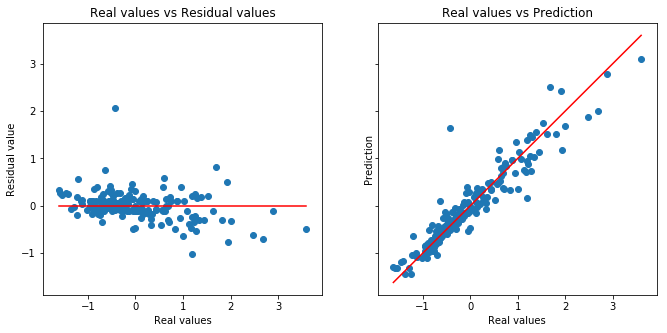

In [36]:
line = [min([min(y_test),min(y_pred)]) , max([max(y_test),max(y_pred)]) ]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight( 5)
f.set_figwidth (11)

residual = y_pred-y_test.T[0]
ax1.plot([ min(y_test) , max(y_test) ],[0,0],color='r')
ax1.scatter(y_test,residual)
ax1.set_title('Real values vs Residual values')
ax1.set_xlabel('Real values')
ax1.set_ylabel('Residual value')

ax2.plot(line,line,color='r')
ax2.scatter(y_test,y_pred)
ax2.set_title('Real values vs Prediction')
ax2.set_xlabel('Real values')
ax2.set_ylabel('Prediction')

plt.show()